## **Install packages**

In [11]:
# Run this cell if you haven't installed these packages
%%capture
!pip install datasets
!pip install gensim
!pip install sentence-transformers
!pip install contractions
!pip install nltk
!pip install scikit-learn
!python -m spacy download en_core_web_md

!pip install transformers tensorflow
!pip install tensorflow-model-optimization


## **Import liabraries**

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import time
import string
import joblib
import re
import os
import shutil
import math

import numpy as np
import pandas as pd
import contractions
import spacy
import nltk

import lightgbm as lgb
import xgboost as xgb

from gensim.models.fasttext import FastText
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import torch
import tensorflow as tf
#import tensorflow_model_optimization as tfmot

from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel
#from transformers import TFBertModel
#from transformers import TFBertForSequenceClassification
from transformers import RobertaTokenizer
from transformers import RobertaModel
from gensim.models import Word2Vec

from sentence_transformers import util
from sentence_transformers import CrossEncoder
from sentence_transformers.cross_encoder.evaluation import CEBinaryClassificationEvaluator
from sentence_transformers import InputExample
from sentence_transformers import SentenceTransformer
from sentence_transformers.quantization import quantize_embeddings
from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics.pairwise import cosine_similarity
#from mlxtend.plotting import plot_confusion_matrix
from nltk.tokenize import word_tokenize

#from google.colab import drive
#drive.mount('/content/drive')
#file_path = '/content/drive/My Drive/'


2024-04-24 11:21:46.709771: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-24 11:21:48.886299: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-24 11:21:52.345335: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/mullah/conda/envs/acava/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/s

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/mullah/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## **Loading dataset**

In [3]:
from datasets import load_dataset
import pandas as pd


# Load the Quora dataset from Hugging Face
quora_dataset = load_dataset('quora')

# Convert the dataset to a pandas DataFrame
dframe = quora_dataset['train'].to_pandas()
dframe.head()



,questions,is_duplicate
0,"{'id': [1, 2], 'text': ['What is the step by s...",False
1,"{'id': [3, 4], 'text': ['What is the story of ...",False
2,"{'id': [5, 6], 'text': ['How can I increase th...",False
3,"{'id': [7, 8], 'text': ['Why am I mentally ver...",False
4,"{'id': [9, 10], 'text': ['Which one dissolve i...",False


## **Splitting corpus into test and train data**

In [4]:
#splitting of data first
df_train, df_test = train_test_split(dframe,
                                   test_size=0.3,
                                   stratify=dframe['is_duplicate'],
                                   random_state=42)

df_train.reset_index(drop=True,inplace=True)
df_test.reset_index(drop=True,inplace=True)

print("Training data shape:",df_train.shape)
print("Test data shape:",df_test.shape)

Training data shape: (283003, 2)
Test data shape: (121287, 2)


In [5]:
df_train

,questions,is_duplicate
0,"{'id': [11069, 240809], 'text': ['How do I gai...",True
1,"{'id': [6787, 6788], 'text': ['What is unusual...",False
2,"{'id': [170658, 170659], 'text': ['How can I m...",False
3,"{'id': [336441, 336442], 'text': ['How much ca...",True
4,"{'id': [51302, 226085], 'text': ['How can I tr...",False
...,...,...
282998,"{'id': [216648, 74022], 'text': ['What is best...",True
282999,"{'id': [8461, 35301], 'text': ['How do I impro...",True
283000,"{'id': [435756, 435757], 'text': ['Would you b...",False
283001,"{'id': [364945, 364946], 'text': ['What is the...",False


In [6]:
df_test

,questions,is_duplicate
0,"{'id': [398338, 511809], 'text': ['Was it appr...",True
1,"{'id': [120456, 473749], 'text': ['I have forg...",False
2,"{'id': [326090, 326091], 'text': ['What book d...",False
3,"{'id': [341728, 341729], 'text': ['How do you ...",True
4,"{'id': [314306, 442046], 'text': ['I've seen b...",False
...,...,...
121282,"{'id': [354415, 354416], 'text': ['What was th...",True
121283,"{'id': [303892, 171844], 'text': ['Is there an...",False
121284,"{'id': [185806, 67162], 'text': ['What is the ...",False
121285,"{'id': [190839, 190840], 'text': ['How can I g...",False


## **Splitting the questions in train dataset**

Questions column has been split into two questions columns 
 - 'text_question1' and
 - 'text_question2'

In [7]:
#spliting the questions in train dataset
# Sample data
data = {
    'questions': [
        {"id": [1, 2], "text": ["What is the step by step guide to invest in share market in india?", "What is the step by step guide to invest in share market?"]},
        {"id": [3, 4], "text": ["What is the story of Kohinoor (Koh-i-Noor) Diamond?", "What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?"]}
    ],
    'is_duplicate': [False, False]
}

# Create DataFrame
#df = pd.DataFrame(df_train)
# Empty lists to store split data
id_list_question1 = []
text_list_question1 = []
id_list_question2 = []
text_list_question2 = []
is_duplicate_list = []

# Iterate through rows
for index, row in df_train.iterrows():
    ids = row['questions']['id']
    texts = row['questions']['text']
    is_duplicate = row['is_duplicate']

    if len(ids) == 2:  # If there's a pair of questions
        id_list_question1.append(ids[0])
        text_list_question1.append(texts[0])
        id_list_question2.append(ids[1])
        text_list_question2.append(texts[1])
    else:  # If there's only one question
        id_list_question1.append(ids[0])
        text_list_question1.append(texts[0])
        id_list_question2.append(None)
        text_list_question2.append(None)

    is_duplicate_list.append(is_duplicate)

# Create new DataFrame
train_data = pd.DataFrame({
                       'text_question1': text_list_question1,
                       'text_question2': text_list_question2,
                       'is_duplicate': is_duplicate_list})
print(train_data)

                                           text_question1  \
0       How do I gain healthy weight without eating junk?   
1       What is unusual or different about the food an...   
2       How can I make music player with sensor in and...   
3                  How much can you charge for a website?   
4                     How can I treat a swollen clitoris?   
...                                                   ...   
282998  What is best way for preparing civil services ...   
282999              How do I improve my English speaking?   
283000  Would you beat a man up if he talked and flirt...   
283001  What is the difference between media and liter...   
283002               What is corporate events management?   

                                           text_question2  is_duplicate  
0       What are the healthy ways of gaining weight an...          True  
1       What is unusual or different about the food an...         False  
2                How can I make music player 

In [8]:
train_data.head(5)

,text_question1,text_question2,is_duplicate
0,How do I gain healthy weight without eating junk?,What are the healthy ways of gaining weight an...,True
1,What is unusual or different about the food an...,What is unusual or different about the food an...,False
2,How can I make music player with sensor in and...,How can I make music player for android?,False
3,How much can you charge for a website?,How much I can charge for a website?,True
4,How can I treat a swollen clitoris?,How do you treat a swollen tongue?,False


## **Splitting the questions in test dataset**

Questions column has been split into two questions columns 'text_question1' and 'text_question2'

In [9]:
#splitting the data in test dataset

#df = pd.DataFrame(df_test)
# Empty lists to store split data
id_list_question1 = []
text_list_question1 = []
id_list_question2 = []
text_list_question2 = []
is_duplicate_list = []

# Iterate through rows
for index, row in df_test.iterrows():
    ids = row['questions']['id']
    texts = row['questions']['text']
    is_duplicate = row['is_duplicate']

    if len(ids) == 2:  # If there's a pair of questions
        id_list_question1.append(ids[0])
        text_list_question1.append(texts[0])
        id_list_question2.append(ids[1])
        text_list_question2.append(texts[1])
    else:  # If there's only one question
        id_list_question1.append(ids[0])
        text_list_question1.append(texts[0])
        id_list_question2.append(None)
        text_list_question2.append(None)

    is_duplicate_list.append(is_duplicate)

# Create new DataFrame
test_data = pd.DataFrame({
                       'text_question1': text_list_question1,

                       'text_question2': text_list_question2,
                       'is_duplicate': is_duplicate_list})

test_data.head(5)

,text_question1,text_question2,is_duplicate
0,Was it appropriate for Meryl Streep to use her...,Should Meryl Streep be using her position to a...,True
1,I have forgot the screen unlock PIN code of my...,How do I unlock my HTC 2200?,False
2,What book do you want to read?,How do you choose what books you read?,False
3,How do you know what is true and what is not?,How do we know what is true and what is not?,True
4,I've seen bald men treated equally as others i...,What do Indian guys think of beautiful bald gi...,False


## **Data Analysis**


Exploratory data analysis is the process of analyzing and summarizing a dataset to gain insights and understanding of its main characteristics. It involves techniques such as data visualization, summary statistics, and data cleaning to discover patterns and relationships within the data. EDA is a crucial step in the data analysis process as it helps to inform subsequent modeling and analysis decisions.



<Axes: xlabel='is_duplicate'>

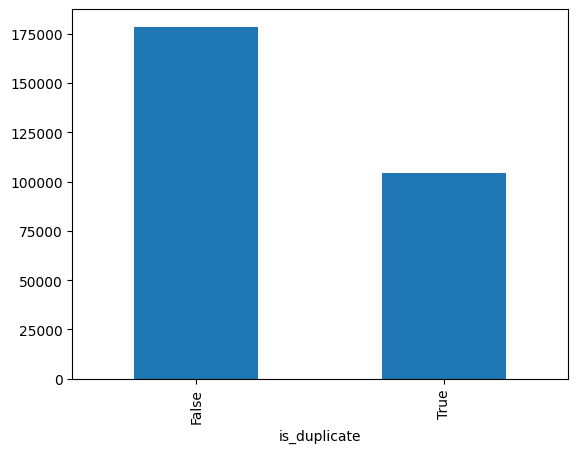

In [10]:
train_data['is_duplicate'].value_counts().plot(kind='bar')

<Axes: xlabel='is_duplicate'>

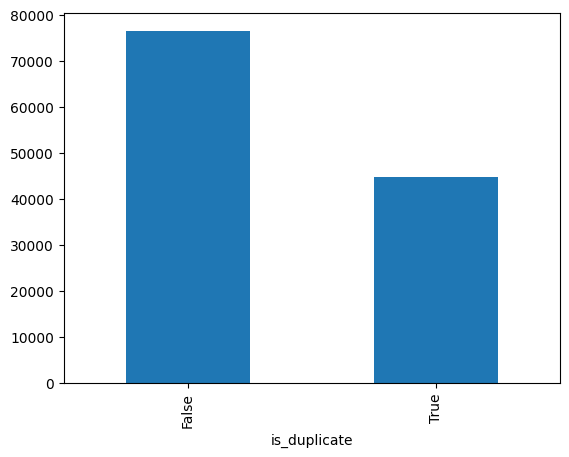

In [11]:
test_data['is_duplicate'].value_counts().plot(kind='bar')


In [12]:
# Repeated question in train dataset
qid = pd.Series(train_data['text_question1'].tolist() + train_data['text_question2'].tolist())
print('Number of unique questions',np.unique(qid).shape[0])

x = qid.value_counts()>1
print('Number of questions getting repeated',x[x].shape[0])


Number of unique questions 403284
Number of questions getting repeated 73299


In [13]:
# Repeated question in test dataset
qid = pd.Series(test_data['text_question1'].tolist() + test_data['text_question2'].tolist())

print('Number of unique questions',np.unique(qid).shape[0])
x = qid.value_counts()>1
print('Number of questions getting repeated',x[x].shape[0])

Number of unique questions 196769
Number of questions getting repeated 24901


## **Feature Engineering**

Let us now construct a few features like:

freq_qid1 = Frequency of qid1's
freq_qid2 = Frequency of qid2's
q1len = Length of q1
q2len = Length of q2
q1_n_words = Number of words in Question 1
q2_n_words = Number of words in Question 2
word_Common = (Number of common unique words in Question 1 and Question 2)
word_Total =(Total num of words in Question 1 + Total num of words in Question 2)
word_share = (word_common)/(word_Total)
freq_q1+freq_q2 = sum total of frequency of qid1 and qid2
freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2

In [14]:
#Feature engineering
df = train_data.sample(10000)
df['freq_qid1'] = df.groupby('text_question1')['text_question2'].transform('count')
df['freq_qid2'] = df.groupby('text_question2')['text_question2'].transform('count')
df['q1len'] = df['text_question1'].str.len()
df['q2len'] = df['text_question2'].str.len()
df['q1_words'] = df['text_question1'].apply(lambda x: len(x.split(" ")))
df['q2_words'] = df['text_question2'].apply(lambda x: len(x.split(" ")))

def normalized_word_count(row):
    w1 = set(map(lambda word: word.lower().strip(), row['text_question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['text_question2'].split(" ")))
    return 1.0 * (len(w1 & w2))
df['word_common'] = df.apply(normalized_word_count, axis = 1)


def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['text_question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['text_question2'].split(" ")))
    return 1.0 * (len(w1) + len(w2))
df['word_Total'] = df.apply(normalized_word_Total, axis=1)

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['text_question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['text_question2'].split(" ")))
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
df['word_share'] = df.apply(normalized_word_share, axis=1)

df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])



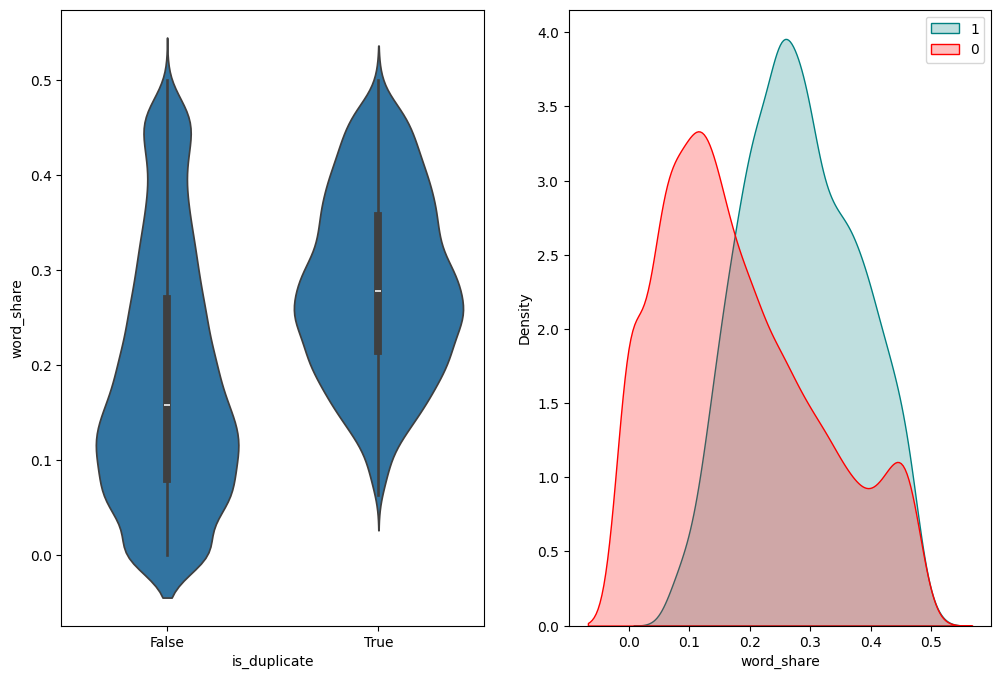

In [15]:
plt.figure(figsize = (12, 8))

plt.subplot(1, 2, 1)
sns.violinplot(x = "is_duplicate", y = "word_share", data = df)

plt.subplot(1, 2, 2)
sns.kdeplot(df[df['is_duplicate'] == 1]['word_share'], label = '1', color='teal', fill = True)
sns.kdeplot(df[df['is_duplicate'] == 0]['word_share'], label = '0', color='red', fill = True)
plt.legend()
plt.show()

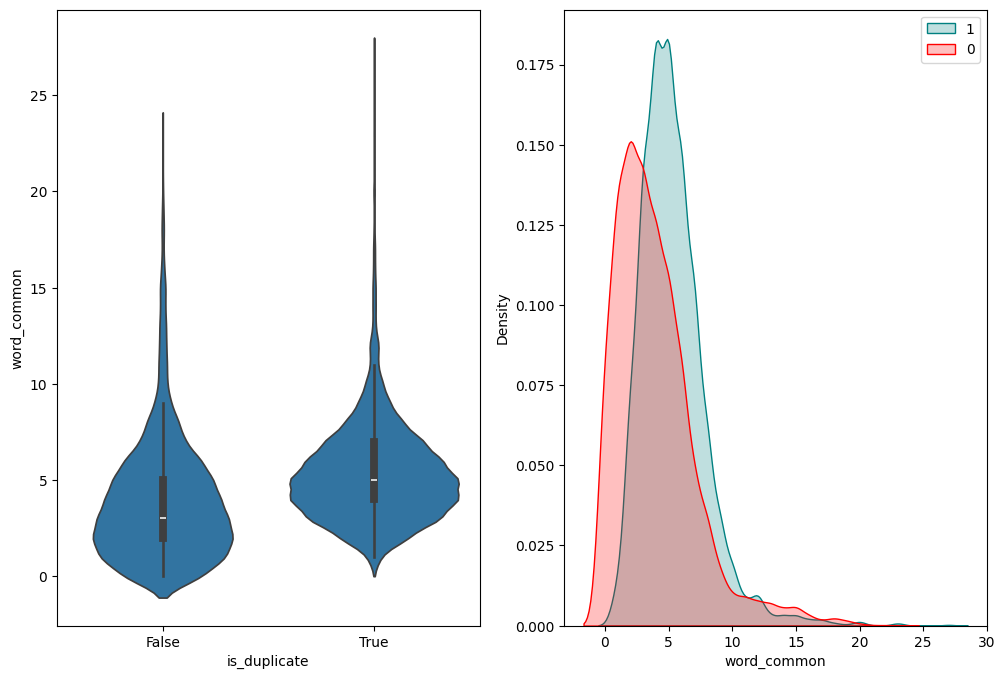

In [16]:
plt.figure(figsize = (12, 8))

plt.subplot(1, 2, 1)
sns.violinplot(x = "is_duplicate", y = "word_common", data = df)

plt.subplot(1, 2, 2)
sns.kdeplot(df[df['is_duplicate'] == 1]['word_common'], label = '1', color='teal', fill = True)
sns.kdeplot(df[df['is_duplicate'] == 0]['word_common'], label = '0', color='red', fill = True)
plt.legend()
plt.show()

Both of the plots presented in the analysis suggest that there is significant overlap between the distributions of the word_Common feature in similar and non-similar questions. This means that the word_Common feature alone may not be a strong enough indicator to determine whether two questions are similar or not. It is important to take into account other features as well when building models for identifying duplicate questions, in order to achieve a high level of accuracy.

## **Pre-processing of data**

In [17]:
#Pre-processing of data
def preprocess_data(text):
    # convert to string
    text = str(text)
    # lowercase
    text = text.lower()
    # remove contractions
    text = contractions.fix(text)
    # remove hashtags
    text = re.sub(r'#(\w+)','',text)
    # remove special characters
    text = re.sub(r'[^\w ]+','',text)
    # remove links if any
    text = re.sub(r'https?://\S+|www\.\S+','',text)
    # remove non-ascii
    text = ''.join(word for word in text if ord(word) < 128)
    # remove punctuation
    text = text.translate(str.maketrans('','',string.punctuation))
    # remove digits
    text = re.sub(r'[\d]+','',text)
    # remove single letters
    text = ' '.join(word for word in text.split() if len(word) > 1)
    # remove multiple spaces
    text = ' '.join(text.split())

    return text

Applying pre-process data to train data

In [18]:
train_data_preprocessed = train_data.copy() # Create a copy of the original dataframe

#change the name to df_train_preprocess
train_data_preprocessed.loc[:,"text_question1"] = train_data_preprocessed["text_question1"].apply(preprocess_data)
train_data_preprocessed.loc[:,"text_question2"] = train_data_preprocessed["text_question2"].apply(preprocess_data)
train_data_preprocessed.head()

,text_question1,text_question2,is_duplicate
0,how do gain healthy weight without eating junk,what are the healthy ways of gaining weight an...,True
1,what is unusual or different about the food an...,what is unusual or different about the food an...,False
2,how can make music player with sensor in android,how can make music player for android,False
3,how much can you charge for website,how much can charge for website,True
4,how can treat swollen clitoris,how do you treat swollen tongue,False


Applying pre-process data to test data

In [19]:
test_data_preprocessed = test_data.copy() # Create a copy of the original dataframe
test_data_preprocessed.loc[:,"text_question1"] = test_data_preprocessed["text_question1"].apply(preprocess_data)
test_data_preprocessed.loc[:,"text_question2"] = test_data_preprocessed["text_question2"].apply(preprocess_data)
test_data_preprocessed.head()

,text_question1,text_question2,is_duplicate
0,was it appropriate for meryl streep to use her...,should meryl streep be using her position to a...,True
1,have forgot the screen unlock pin code of my h...,how do unlock my htc,False
2,what book do you want to read,how do you choose what books you read,False
3,how do you know what is true and what is not,how do we know what is true and what is not,True
4,have seen bald men treated equally as others i...,what do indian guys think of beautiful bald girls,False


# **TF-IDF**

In [20]:
# Fit Tfidf Vectorizer of train & test dataset
tfidf = TfidfVectorizer()
train_tfidf = tfidf.fit_transform(train_data_preprocessed['text_question1'] + ' ' + 
                                  train_data_preprocessed['text_question2'])

#no. of feature
test_tfidf = tfidf.transform(test_data_preprocessed['text_question1'] + ' ' + 
                             test_data_preprocessed['text_question2'])

train_tfidf.shape, test_tfidf.shape

((283003, 82815), (121287, 82815))

## **XGBclassification (TF-IDF representation)**

In [21]:
labels = train_data_preprocessed['is_duplicate']
model_xgb = xgb.XGBClassifier()
model_xgb.fit(train_tfidf,labels)

train_predictions = model_xgb.predict(train_tfidf)
train_predictions = list(train_predictions)

print('Train Accuracy score:',accuracy_score(train_data_preprocessed['is_duplicate'], train_predictions))
print("Classification Report:\n", classification_report(train_data_preprocessed['is_duplicate'], train_predictions))

test_predictions = model_xgb.predict(test_tfidf)
test_predictions = list(test_predictions)

print('Test Accuracy score: ',accuracy_score(test_data_preprocessed['is_duplicate'], test_predictions))
print("Classification Report:\n", classification_report(test_data_preprocessed['is_duplicate'], test_predictions))

Train Accuracy score: 0.7662568948032353
Classification Report:
               precision    recall  f1-score   support

       False       0.77      0.90      0.83    178519
        True       0.76      0.54      0.63    104484

    accuracy                           0.77    283003
   macro avg       0.76      0.72      0.73    283003
weighted avg       0.76      0.77      0.76    283003

Test Accuracy score:  0.7507729600039575
Classification Report:
               precision    recall  f1-score   support

       False       0.76      0.88      0.82     76508
        True       0.73      0.52      0.61     44779

    accuracy                           0.75    121287
   macro avg       0.74      0.70      0.71    121287
weighted avg       0.75      0.75      0.74    121287



## **LightGBM Classifier (TF-IDF representation)**

In [22]:
# Train LightGBM Classifier
model_lgb = lgb.LGBMClassifier()
model_lgb.fit(train_tfidf,labels)

# Predictions and evaluation
train_predictions = model_lgb.predict(train_tfidf)
print('Train Accuracy score:', accuracy_score(labels, train_predictions))
print("Classification Report:\n", classification_report(labels, train_predictions))

test_predictions = model_lgb.predict(test_tfidf)
test_predictions = list(test_predictions)

print('Test Accuracy score:',accuracy_score(test_data_preprocessed['is_duplicate'],test_predictions))
print("Classification Report:\n", classification_report(test_data_preprocessed['is_duplicate'],test_predictions))

[LightGBM] [Info] Number of positive: 104484, number of negative: 178519
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.814005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 407228
[LightGBM] [Info] Number of data points in the train set: 283003, number of used features: 10339
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.369197 -> initscore=-0.535661
[LightGBM] [Info] Start training from score -0.535661
Train Accuracy score: 0.7516846111171966
Classification Report:
               precision    recall  f1-score   support

       False       0.76      0.89      0.82    178519
        True       0.73      0.51      0.60    104484

    accuracy                           0.75    283003
   macro avg       0.75      0.70      0.71    283003
weighted avg       0.75      0.75      0.74    283003

Test Accuracy score: 0.7460651182731868
Classification Report:
               precision    recall  f1-scor

# **Word2Vec**

## Word2Vec using word tokenization on train data

In [23]:
# Assuming 'processed_questions' contains preprocessed text
X = train_data_preprocessed[['text_question1', 'text_question2']]
y = train_data_preprocessed['is_duplicate']

# Tokenize the sentences
tokenized_sentences_q1 = X['text_question1'].apply(lambda x: str(x).split())
tokenized_sentences_q2 = X['text_question2'].apply(lambda x: str(x).split())

In [24]:
tokenized_sentences = list(tokenized_sentences_q1)
tokenized_sentences.extend(list(tokenized_sentences_q2))
len(tokenized_sentences_q1), len(tokenized_sentences_q2), len(tokenized_sentences)

(283003, 283003, 566006)

In [25]:
word2vec_model = Word2Vec(sentences=tokenized_sentences, 
                             vector_size=100, 
                             window=5, 
                             min_count=1, 
                             workers=4)


In [26]:
# Train Word2Vec model
#word2vec_model_q1 = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4)
#word2vec_model_q2 = Word2Vec(sentences=tokenized_sentences_q2, vector_size=100, window=5, min_count=1, workers=4)

# Function to get the vector representation of a sentence
def get_sentence_vector(sentence, model):
    vector = np.zeros(model.vector_size)
    count = 0
    for word in sentence:
        if word in model.wv:
            vector += model.wv[word]
            count += 1
    if count != 0:
        vector /= count
    return vector

# Create feature vectors for each question
X_q1 = np.array([get_sentence_vector(sentence, word2vec_model) for sentence in tokenized_sentences_q1])
X_q2 = np.array([get_sentence_vector(sentence, word2vec_model) for sentence in tokenized_sentences_q2])

# Concatenate the feature vectors
X_train_combined = np.concatenate((X_q1, X_q2), axis=1)

labels = train_data_preprocessed['is_duplicate']
model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_train_combined, labels)

train_predictions = model_xgb.predict(X_train_combined)
train_predictions = list(train_predictions)
print('Train Accuracy score:', accuracy_score(train_data_preprocessed['is_duplicate'], train_predictions))
print("Classification Report:\n", classification_report(train_data_preprocessed['is_duplicate'], train_predictions))

Train Accuracy score: 0.8130443846885015
Classification Report:
               precision    recall  f1-score   support

       False       0.83      0.89      0.86    178519
        True       0.78      0.68      0.73    104484

    accuracy                           0.81    283003
   macro avg       0.81      0.79      0.79    283003
weighted avg       0.81      0.81      0.81    283003



In [27]:
# Train LightGBM Classifier
model_lgb = lgb.LGBMClassifier()
model_lgb.fit(X_train_combined, labels)

# Predictions and evaluation
train_predictions = model_lgb.predict(X_train_combined)
print('Train Accuracy score:', accuracy_score(labels, train_predictions))
print("Classification Report:\n", classification_report(labels, train_predictions))

[LightGBM] [Info] Number of positive: 104484, number of negative: 178519
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 283003, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.369197 -> initscore=-0.535661
[LightGBM] [Info] Start training from score -0.535661
Train Accuracy score: 0.7643982572622905
Classification Report:
               precision    recall  f1-score   support

       False       0.78      0.87      0.82    178519
        True       0.72      0.59      0.65    104484

    accuracy                           0.76    283003
   macro avg       0.75      0.73      0.74    283003
weighted avg       0.76      0.76      0.76    283003



## Word2Vec using word tokenization on test data

In [28]:
# Assuming 'processed_questions' contains preprocessed text
X = test_data_preprocessed[['text_question1', 'text_question2']]
y = test_data_preprocessed['is_duplicate']

# Tokenize the sentences
tokenized_sentences_q1 = X['text_question1'].apply(lambda x: str(x).split())
tokenized_sentences_q2 = X['text_question2'].apply(lambda x: str(x).split())

In [29]:
# Train Word2Vec model
#word2vec_model_q1 = Word2Vec(sentences=tokenized_sentences_q1, vector_size=100, window=5, min_count=1, workers=4)
#word2vec_model_q2 = Word2Vec(sentences=tokenized_sentences_q2, vector_size=100, window=5, min_count=1, workers=4)

# Function to get the vector representation of a sentence
def get_sentence_vector(sentence, model):
    vector = np.zeros(model.vector_size)
    count = 0
    for word in sentence:
        if word in model.wv:
            vector += model.wv[word]
            count += 1
    if count != 0:
        vector /= count
    return vector

# Create feature vectors for each question
X_q1 = np.array([get_sentence_vector(sentence, word2vec_model) for sentence in tokenized_sentences_q1])
X_q2 = np.array([get_sentence_vector(sentence, word2vec_model) for sentence in tokenized_sentences_q2])

# Concatenate the feature vectors
X_test_combined = np.concatenate((X_q1, X_q2), axis=1)


#labels = test_data_preprocessed['is_duplicate']
#model_xgb = xgb.XGBClassifier()
#model_xgb.fit(X_combined, labels)


predictions_test = model_xgb.predict(X_test_combined)
predictions_test = list(predictions_test)
print('Test Accuracy score:',accuracy_score(test_data_preprocessed['is_duplicate'],predictions_test))
print("Classification Report:\n", classification_report(test_data_preprocessed['is_duplicate'],predictions_test))

Test Accuracy score: 0.7707091444260308
Classification Report:
               precision    recall  f1-score   support

       False       0.80      0.86      0.83     76508
        True       0.72      0.62      0.67     44779

    accuracy                           0.77    121287
   macro avg       0.76      0.74      0.75    121287
weighted avg       0.77      0.77      0.77    121287



In [30]:
# Train LightGBM Classifier
#model_lgb = lgb.LGBMClassifier()
#model_lgb.fit(X_test_combined, labels)

predictions_test=model_lgb.predict(X_test_combined)
predictions_test = list(predictions_test)
print('Test Accuracy score:',accuracy_score(test_data_preprocessed['is_duplicate'],predictions_test))
print("Classification Report:\n", classification_report(test_data_preprocessed['is_duplicate'],predictions_test))


Test Accuracy score: 0.7548459439181445
Classification Report:
               precision    recall  f1-score   support

       False       0.78      0.86      0.82     76508
        True       0.71      0.57      0.63     44779

    accuracy                           0.75    121287
   macro avg       0.74      0.72      0.72    121287
weighted avg       0.75      0.75      0.75    121287



# **GloVe (Spacy)**

###  Load SpaCy  for tokenization

In [31]:
nlp = spacy.load("en_core_web_md")

### Load GloVe embeddings

In [32]:
#from gensim.scripts.glove2word2vec import glove2word2vec
#load the GloVe word embeddings file which has a 100 dimension representation for each word. Convert that into a word2vec supported format
#glove2word2vec('glove.6B.100d.txt','word2vec.glove.6B.100d.txt')

In [33]:
def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    return embeddings_index

#glove_embeddings = load_glove_embeddings('/content/drive/My Drive/glove.6B.100d.txt')

### **Function to embed questions using SpaCy tokenization and GloVe on train data**

In [34]:
def embed_question(question, model):
    tokens = [token.vector for token in model(question)]
    return np.mean(tokens, axis=0)

#sample_size = 1000  # Adjust as needed
#sampled_df = df_preprocess_train.sample(n=sample_size, random_state=42)
sampled_df = train_data.copy()

# Function to calculate cosine similarity between two embeddings
def cosine_similarity(embedding1, embedding2):
    return np.dot(embedding1, embedding2) / (np.linalg.norm(embedding1) * np.linalg.norm(embedding2))

# Preprocess the data and create embeddings for each question pair
train_embeddings = []
labels = []
for idx, row in sampled_df.iterrows():
    q1_embedding = embed_question(row['text_question1'], nlp)
    q2_embedding = embed_question(row['text_question2'], nlp)
    combined_embedding = np.abs(q1_embedding - q2_embedding)  # Combine embeddings
    train_embeddings.append(combined_embedding)
    labels.append(row['is_duplicate'])

/home/mullah/conda/envs/acava/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mullah/conda/envs/acava/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [35]:
model_xgb = xgb.XGBClassifier()
model_xgb.fit(train_embeddings,labels)

predictions_train = model_xgb.predict(train_embeddings)
predictions_train = list(predictions_train)
print('Train Accuracy score:',accuracy_score(sampled_df['is_duplicate'],predictions_train))
print("Classification Report:\n", classification_report(sampled_df['is_duplicate'],predictions_train))

Train Accuracy score: 0.7431970685823118
Classification Report:
               precision    recall  f1-score   support

       False       0.77      0.85      0.81    178519
        True       0.69      0.55      0.61    104484

    accuracy                           0.74    283003
   macro avg       0.73      0.70      0.71    283003
weighted avg       0.74      0.74      0.74    283003



In [36]:
# Train LightGBM Classifier
model_lgb = lgb.LGBMClassifier()
model_lgb.fit(train_embeddings,labels)

# Predictions and evaluation
predictions_train = model_lgb.predict(train_embeddings)
predictions_train = list(predictions_train)
print('Train Accuracy score:', accuracy_score(labels, predictions_train))
print("Classification Report:\n", classification_report(labels, predictions_train))

[LightGBM] [Info] Number of positive: 104484, number of negative: 178519
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 283003, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.369197 -> initscore=-0.535661
[LightGBM] [Info] Start training from score -0.535661
Train Accuracy score: 0.7027558011752526
Classification Report:
               precision    recall  f1-score   support

       False       0.73      0.85      0.78    178519
        True       0.64      0.45      0.53    104484

    accuracy                           0.70    283003
   macro avg       0.68      0.65      0.66    283003
weighted avg       0.69      0.70      0.69    283003



### Function to embed questions using SpaCy and GloVe on test data

In [37]:

# Function to embed questions using SpaCy and GloVe
def embed_question(question, model):
    tokens = [token.vector for token in model(question)]
    return np.mean(tokens, axis=0)

#sample_size = 1000  # Adjust as needed
#sampled_df = df_preprocess_test.sample(n=sample_size, random_state=42)
sampled_df = test_data.copy()

# Function to calculate cosine similarity between two embeddings
def cosine_similarity(embedding1, embedding2):
    return np.dot(embedding1, embedding2) / (np.linalg.norm(embedding1) * np.linalg.norm(embedding2))

    # Preprocess the data and create embeddings for each question pair
test_embeddings = []
labels = []
for idx, row in sampled_df.iterrows():
    q1_embedding = embed_question(row['text_question1'], nlp)
    q2_embedding = embed_question(row['text_question2'], nlp)
    combined_embedding = np.abs(q1_embedding - q2_embedding)  # Combine embeddings
    test_embeddings.append(combined_embedding)
    labels.append(row['is_duplicate'])

/home/mullah/conda/envs/acava/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mullah/conda/envs/acava/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [38]:
#model_xgb = xgb.XGBClassifier()
#model_xgb.fit(test_embeddings, labels)

predictions_test = model_xgb.predict(test_embeddings)
predictions_test = list(predictions_test)
print('Test Accuracy score: ', accuracy_score(sampled_df['is_duplicate'],predictions_test))
print("Classification Report:\n ", classification_report(sampled_df['is_duplicate'],predictions_test))

Test Accuracy score:  0.6921351834903988
Classification Report:
                precision    recall  f1-score   support

       False       0.73      0.82      0.77     76508
        True       0.61      0.47      0.53     44779

    accuracy                           0.69    121287
   macro avg       0.67      0.65      0.65    121287
weighted avg       0.68      0.69      0.68    121287



In [39]:
# Train LightGBM Classifier
#model_lgb = lgb.LGBMClassifier()
#model_lgb.fit(embeddings,labels)

predictions_test = model_xgb.predict(test_embeddings)
predictions_test = list(predictions_test)
print('Test Accuracy score:', accuracy_score(sampled_df['is_duplicate'], predictions_test))
print("Classification Report:\n", classification_report(sampled_df['is_duplicate'], predictions_test))

Test Accuracy score: 0.6921351834903988
Classification Report:
               precision    recall  f1-score   support

       False       0.73      0.82      0.77     76508
        True       0.61      0.47      0.53     44779

    accuracy                           0.69    121287
   macro avg       0.67      0.65      0.65    121287
weighted avg       0.68      0.69      0.68    121287



# **SBERT**

In [40]:
#Load pre-trained model
model_name = 'paraphrase-distilroberta-base-v2'
model = SentenceTransformer(model_name)

## **SBERT applied on train data**

In [41]:
#sample_size = 3000  # Adjust as needed
#sampled_df = new_df_train.sample(n=sample_size, random_state=52)
sampled_df = train_data.copy()

# Encode questions using SBERT model
question1_embeddings = model.encode(sampled_df['text_question1'].tolist())
question2_embeddings = model.encode(sampled_df['text_question2'].tolist())

X_train_combined = np.concatenate((question1_embeddings, question2_embeddings), axis=1)

# Generate labels for the sampled data
labels = sampled_df['is_duplicate'].values

model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_train_combined,labels)

predictions_train = model_xgb.predict(X_train_combined)
predictions_train = list(predictions_train)
print('Train Accuracy score:',accuracy_score(sampled_df['is_duplicate'],predictions_train))
print("Classification Report:\n", classification_report(sampled_df['is_duplicate'],predictions_train))


Train Accuracy score: 0.8845065246658163
Classification Report:
               precision    recall  f1-score   support

       False       0.91      0.90      0.91    178519
        True       0.84      0.85      0.84    104484

    accuracy                           0.88    283003
   macro avg       0.88      0.88      0.88    283003
weighted avg       0.88      0.88      0.88    283003



In [42]:
# Train LightGBM Classifier
model_lgb = lgb.LGBMClassifier()
model_lgb.fit(X_train_combined, labels)

# Predictions and evaluation
predictions_train = model_lgb.predict(X_train_combined)
print('Train Accuracy score:', accuracy_score(labels, predictions_train))
print("Classification Report:\n", classification_report(labels, predictions_train))

[LightGBM] [Info] Number of positive: 104484, number of negative: 178519
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.666601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 391680
[LightGBM] [Info] Number of data points in the train set: 283003, number of used features: 1536
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.369197 -> initscore=-0.535661
[LightGBM] [Info] Start training from score -0.535661
Train Accuracy score: 0.8397190135793613
Classification Report:
               precision    recall  f1-score   support

       False       0.86      0.89      0.87    178519
        True       0.80      0.76      0.78    104484

    accuracy                           0.84    283003
   macro avg       0.83      0.82      0.83    283003
weighted avg       0.84      0.84      0.84    283003



## **SBERT applied on test data**

In [43]:
#sample_size = 3000  # Adjust as needed
#sampled_df = new_df_test.sample(n=sample_size, random_state=52)
#sampled_df=new_df_train
sampled_df = test_data.copy()

# Encode questions using SBERT model
question1_embeddings = model.encode(sampled_df['text_question1'].tolist())
question2_embeddings = model.encode(sampled_df['text_question2'].tolist())

X_test_combined = np.concatenate((question1_embeddings, question2_embeddings), axis=1)

# Generate labels for the sampled data
labels = sampled_df['is_duplicate'].values


#model_xgb = xgb.XGBClassifier()
#model_xgb.fit(X_test_combined,labels)

predictions_test=model_xgb.predict(X_test_combined)
print('Test Accuracy score:',accuracy_score(sampled_df['is_duplicate'],predictions_test))
print("Classification Report:\n", classification_report(sampled_df['is_duplicate'],predictions_test))

Test Accuracy score: 0.847403266632038
Classification Report:
               precision    recall  f1-score   support

       False       0.88      0.88      0.88     76508
        True       0.79      0.80      0.79     44779

    accuracy                           0.85    121287
   macro avg       0.84      0.84      0.84    121287
weighted avg       0.85      0.85      0.85    121287



In [44]:
# Train LightGBM Classifier
#model_lgb = lgb.LGBMClassifier()
#model_lgb.fit(X_test_combined, labels)

# Predictions and evaluation
predictions_test = model_lgb.predict(X_test_combined)
print('Test Accuracy score:', accuracy_score(labels, predictions_test))
print("Classification Report:\n", classification_report(labels, predictions_test))

Test Accuracy score: 0.8330241493317503
Classification Report:
               precision    recall  f1-score   support

       False       0.86      0.88      0.87     76508
        True       0.79      0.75      0.77     44779

    accuracy                           0.83    121287
   macro avg       0.82      0.81      0.82    121287
weighted avg       0.83      0.83      0.83    121287



# SBERT (Quantisation)

In [45]:
train_binary_embeddings = quantize_embeddings(X_train_combined, precision="binary")
test_binary_embeddings = quantize_embeddings(X_test_combined, precision="binary")

In [46]:
len(train_binary_embeddings), len(train_data.values)

(283003, 283003)

## **SBERT (Quantisation) applied on Train data**

In [47]:
# Generate labels for the sampled data
labels = train_data['is_duplicate'].values

model_xgb = xgb.XGBClassifier()
model_xgb.fit(train_binary_embeddings, labels)

predictions_train = model_xgb.predict(train_binary_embeddings)
predictions_train = list(predictions_train)
print('Train Accuracy score:',accuracy_score(labels,predictions_train))
print("Classification Report:\n", classification_report(labels,predictions_train))

Train Accuracy score: 0.8586799433221556
Classification Report:
               precision    recall  f1-score   support

       False       0.88      0.90      0.89    178519
        True       0.82      0.79      0.80    104484

    accuracy                           0.86    283003
   macro avg       0.85      0.84      0.85    283003
weighted avg       0.86      0.86      0.86    283003



In [48]:
# Train LightGBM Classifier
model_lgb = lgb.LGBMClassifier()
model_lgb.fit(train_binary_embeddings, labels)

# Predictions and evaluation
predictions_train = model_lgb.predict(train_binary_embeddings)
print('Train Accuracy score:', accuracy_score(labels, predictions_train))
print("Classification Report:\n", classification_report(labels, predictions_train))

[LightGBM] [Info] Number of positive: 104484, number of negative: 178519
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45789
[LightGBM] [Info] Number of data points in the train set: 283003, number of used features: 192
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.369197 -> initscore=-0.535661
[LightGBM] [Info] Start training from score -0.535661
Train Accuracy score: 0.8095391214934118
Classification Report:
               precision    recall  f1-score   support

       False       0.82      0.90      0.86    178519
        True       0.79      0.66      0.72    104484

    accuracy                           0.81    283003
   macro avg       0.80      0.78      0.79    283003
weighted avg       0.81      0.81      0.81    283003



## **SBERT (Quantisation) applied on Test data**

In [49]:
#sample_size = 3000  # Adjust as needed
#sampled_df = new_df_test.sample(n=sample_size, random_state=52)
#sampled_df=new_df_train
#sampled_df = test_data.copy()

# Encode questions using SBERT model
#question1_embeddings = model.encode(sampled_df['text_question1'].tolist())
#question2_embeddings = model.encode(sampled_df['text_question2'].tolist())
#X_combined = np.concatenate((question1_embeddings, question2_embeddings), axis=1)

# Generate labels for the sampled data
labels = test_data['is_duplicate'].values


#model_xgb = xgb.XGBClassifier()
#model_xgb.fit(X_combined,labels)

predictions_test=model_xgb.predict(test_binary_embeddings)
print('Test Accuracy score:',accuracy_score(test_data['is_duplicate'],predictions_test))
print("Classification Report:\n", classification_report(test_data['is_duplicate'],predictions_test))

Test Accuracy score: 0.8280359807728775
Classification Report:
               precision    recall  f1-score   support

       False       0.85      0.88      0.87     76508
        True       0.78      0.74      0.76     44779

    accuracy                           0.83    121287
   macro avg       0.82      0.81      0.81    121287
weighted avg       0.83      0.83      0.83    121287



In [50]:
# test LightGBM Classifier
#model_lgb = lgb.LGBMClassifier()
#model_lgb.fit(train_binary_embeddings, labels)

# Predictions and evaluation
predictions_train = model_lgb.predict(test_binary_embeddings)
print('Train Accuracy score:', accuracy_score(labels, predictions_train))
print("Classification Report:\n", classification_report(labels, predictions_train))

Train Accuracy score: 0.8059643655132043
Classification Report:
               precision    recall  f1-score   support

       False       0.81      0.90      0.85     76508
        True       0.79      0.65      0.71     44779

    accuracy                           0.81    121287
   macro avg       0.80      0.77      0.78    121287
weighted avg       0.80      0.81      0.80    121287



# **BERT**

## **Load BERT Model**

In [22]:
# Load the pre-trained RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
roberta_model = RobertaModel.from_pretrained("roberta-base")

# Configure the model for quantization
#roberta_model = roberta_model.eval()  # Put the model in evaluation mode
#roberta_model = torch.quantization.quantize_dynamic(roberta_model, {torch.nn.Linear}, dtype=torch.qint8)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## **Implement BERT on train dataset**

In [ ]:
# Sample size and load data
#sample_size = 3000  # Adjust as needed
#sampled_df = new_df_train.sample(n=sample_size, random_state=52)
sampled_df = train_data

# Tokenize questions using RoBERTa tokenizer
question1_tokens = tokenizer(sampled_df['text_question1'].tolist(), padding=True, truncation=True, return_tensors='pt', max_length=128)
question2_tokens = tokenizer(sampled_df['text_question2'].tolist(), padding=True, truncation=True, return_tensors='pt', max_length=128)

# Encode questions using RoBERTa model with reduced batch size
batch_size = 8
question1_embeddings = []
question2_embeddings = []

with torch.no_grad():  # Disable gradient tracking for efficiency
    for i in range(0, len(sampled_df), batch_size):
        batch_question1_tokens = {k: v[i:i+batch_size] for k, v in question1_tokens.items()}
        batch_question2_tokens = {k: v[i:i+batch_size] for k, v in question2_tokens.items()}

        # Encode questions using RoBERTa model
        batch_question1_outputs = roberta_model(**batch_question1_tokens)
        batch_question2_outputs = roberta_model(**batch_question2_tokens)

        # Extract pooled output (CLS token)
        batch_question1_embeddings = batch_question1_outputs.pooler_output
        batch_question2_embeddings = batch_question2_outputs.pooler_output

        question1_embeddings.append(batch_question1_embeddings)
        question2_embeddings.append(batch_question2_embeddings)

# Concatenate question embeddings
question1_embeddings = torch.cat(question1_embeddings, dim=0)
question2_embeddings = torch.cat(question2_embeddings, dim=0)
X_train_combined = torch.cat([question1_embeddings, question2_embeddings], dim=1).numpy()

# Generate labels for the sampled data
labels = sampled_df['is_duplicate'].values

# Train Gradient Boosting Classifier
model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_train_combined, labels)

# Predictions and evaluation
predictions_train = model_xgb.predict(X_train_combined)
print('Train Accuracy score:', accuracy_score(labels, predictions_train))
print("Classification Report:\n", classification_report(labels, predictions_train))

In [ ]:
# Train LightGBM Classifier
model_lgb = lgb.LGBMClassifier()
model_lgb.fit(X_train_combined, labels)

# Predictions and evaluation
predictions_train = model_lgb.predict(X_train_combined)
print('Train Accuracy score:', accuracy_score(labels, predictions_train))
print("Classification Report:\n", classification_report(labels, predictions_train))

## **Implement BERT Model on test dataset**

In [ ]:
# Sample size and load data
#sample_size = 3000  # Adjust as needed
#sampled_df = new_df_test.sample(n=sample_size, random_state=52)
sampled_df = test_data

# Tokenize questions using RoBERTa tokenizer
question1_tokens = tokenizer(sampled_df['text_question1'].tolist(), padding=True, truncation=True, return_tensors='pt', max_length=128)
question2_tokens = tokenizer(sampled_df['text_question2'].tolist(), padding=True, truncation=True, return_tensors='pt', max_length=128)

# Encode questions using RoBERTa model with reduced batch size
batch_size = 8
question1_embeddings = []
question2_embeddings = []

with torch.no_grad():  # Disable gradient tracking for efficiency
    for i in range(0, len(sampled_df), batch_size):
        batch_question1_tokens = {k: v[i:i+batch_size] for k, v in question1_tokens.items()}
        batch_question2_tokens = {k: v[i:i+batch_size] for k, v in question2_tokens.items()}

        # Encode questions using RoBERTa model
        batch_question1_outputs = roberta_model(**batch_question1_tokens)
        batch_question2_outputs = roberta_model(**batch_question2_tokens)

        # Extract pooled output (CLS token)
        batch_question1_embeddings = batch_question1_outputs.pooler_output
        batch_question2_embeddings = batch_question2_outputs.pooler_output

        question1_embeddings.append(batch_question1_embeddings)
        question2_embeddings.append(batch_question2_embeddings)

# Concatenate question embeddings
question1_embeddings = torch.cat(question1_embeddings, dim=0)
question2_embeddings = torch.cat(question2_embeddings, dim=0)
X_test_combined = torch.cat([question1_embeddings, question2_embeddings], dim=1).numpy()

# Generate labels for the sampled data
labels = sampled_df['is_duplicate'].values

# Train Gradient Boosting Classifier
#model_xgb = xgb.XGBClassifier()
#model_xgb.fit(X_test_combined, labels)

# Predictions and evaluation
predictions_train = model_xgb.predict(X_test_combined)
print('Train Accuracy score:', accuracy_score(labels, predictions_train))
print("Classification Report:\n", classification_report(labels, predictions_train))

In [ ]:
# Train LightGBM Classifier
# model_lgb = lgb.LGBMClassifier()
# model_lgb.fit(X_test_combined, labels)

# Predictions and evaluation
predictions_test = model_lgb.predict(X_test_combined)
print('Test Accuracy score:', accuracy_score(labels, predictions_test))
print("Classification Report:\n", classification_report(labels, predictions_test))

# **BERT (Quantization)**

In [ ]:
# Load the pre-trained RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
roberta_model = RobertaModel.from_pretrained("roberta-base")

# Configure the model for quantization
roberta_model = roberta_model.eval()  # Put the model in evaluation mode
roberta_model = torch.quantization.quantize_dynamic(roberta_model, {torch.nn.Linear}, dtype=torch.qint8)

## **Implement BERT (Quantization) on train dataset**

In [ ]:
# Sample size and load data
#sample_size = 3000  # Adjust as needed
#sampled_df = new_df_train.sample(n=sample_size, random_state=52)
sampled_df = train_data

# Tokenize questions using RoBERTa tokenizer
question1_tokens = tokenizer(sampled_df['text_question1'].tolist(), padding=True, truncation=True, return_tensors='pt', max_length=128)
question2_tokens = tokenizer(sampled_df['text_question2'].tolist(), padding=True, truncation=True, return_tensors='pt', max_length=128)

# Encode questions using RoBERTa model with reduced batch size
batch_size = 8
question1_embeddings = []
question2_embeddings = []

with torch.no_grad():  # Disable gradient tracking for efficiency
    for i in range(0, len(sampled_df), batch_size):
        batch_question1_tokens = {k: v[i:i+batch_size] for k, v in question1_tokens.items()}
        batch_question2_tokens = {k: v[i:i+batch_size] for k, v in question2_tokens.items()}

        # Encode questions using RoBERTa model
        batch_question1_outputs = roberta_model(**batch_question1_tokens)
        batch_question2_outputs = roberta_model(**batch_question2_tokens)

        # Extract pooled output (CLS token)
        batch_question1_embeddings = batch_question1_outputs.pooler_output
        batch_question2_embeddings = batch_question2_outputs.pooler_output

        question1_embeddings.append(batch_question1_embeddings)
        question2_embeddings.append(batch_question2_embeddings)

# Concatenate question embeddings
question1_embeddings = torch.cat(question1_embeddings, dim=0)
question2_embeddings = torch.cat(question2_embeddings, dim=0)
X_train_combined = torch.cat([question1_embeddings, question2_embeddings], dim=1).numpy()

# Generate labels for the sampled data
labels = sampled_df['is_duplicate'].values

# Train Gradient Boosting Classifier
model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_train_combined, labels)

# Predictions and evaluation
predictions_train = model_xgb.predict(X_train_combined)
print('Train Accuracy score:', accuracy_score(labels, predictions_train))
print("Classification Report:\n", classification_report(labels, predictions_train))

In [ ]:
# Train LightGBM Classifier
model_lgb = lgb.LGBMClassifier()
model_lgb.fit(X_train_combined, labels)

# Predictions and evaluation
predictions_train = model_lgb.predict(X_train_combined)
print('Train Accuracy score:', accuracy_score(labels, predictions_train))
print("Classification Report:\n", classification_report(labels, predictions_train))

## **Implement BERT (Quantization) Model on test dataset**

In [ ]:
# Sample size and load data
#sample_size = 3000  # Adjust as needed
#sampled_df = new_df_test.sample(n=sample_size, random_state=52)
sampled_df = test_data

# Tokenize questions using RoBERTa tokenizer
question1_tokens = tokenizer(sampled_df['text_question1'].tolist(), padding=True, truncation=True, return_tensors='pt', max_length=128)
question2_tokens = tokenizer(sampled_df['text_question2'].tolist(), padding=True, truncation=True, return_tensors='pt', max_length=128)

# Encode questions using RoBERTa model with reduced batch size
batch_size = 8
question1_embeddings = []
question2_embeddings = []

with torch.no_grad():  # Disable gradient tracking for efficiency
    for i in range(0, len(sampled_df), batch_size):
        batch_question1_tokens = {k: v[i:i+batch_size] for k, v in question1_tokens.items()}
        batch_question2_tokens = {k: v[i:i+batch_size] for k, v in question2_tokens.items()}

        # Encode questions using RoBERTa model
        batch_question1_outputs = roberta_model(**batch_question1_tokens)
        batch_question2_outputs = roberta_model(**batch_question2_tokens)

        # Extract pooled output (CLS token)
        batch_question1_embeddings = batch_question1_outputs.pooler_output
        batch_question2_embeddings = batch_question2_outputs.pooler_output

        question1_embeddings.append(batch_question1_embeddings)
        question2_embeddings.append(batch_question2_embeddings)

# Concatenate question embeddings
question1_embeddings = torch.cat(question1_embeddings, dim=0)
question2_embeddings = torch.cat(question2_embeddings, dim=0)
X_test_combined = torch.cat([question1_embeddings, question2_embeddings], dim=1).numpy()

# Generate labels for the sampled data
labels = sampled_df['is_duplicate'].values

# Train Gradient Boosting Classifier
#model_xgb = xgb.XGBClassifier()
#model_xgb.fit(X_test_combined, labels)

# Predictions and evaluation
predictions_train = model_xgb.predict(X_test_combined)
print('Train Accuracy score:', accuracy_score(labels, predictions_train))
print("Classification Report:\n", classification_report(labels, predictions_train))

In [ ]:
# Train LightGBM Classifier
# model_lgb = lgb.LGBMClassifier()
# model_lgb.fit(X_test_combined, labels)

# Predictions and evaluation
predictions_test = model_lgb.predict(X_test_combined)
print('Test Accuracy score:', accuracy_score(labels, predictions_test))
print("Classification Report:\n", classification_report(labels, predictions_test))